In [1]:
!git clone -b master https://github.com/HennFarr/Coins.git


Cloning into 'Coins'...
remote: Enumerating objects: 12122, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 12122 (delta 41), reused 51 (delta 23), pack-reused 12044
Receiving objects: 100% (12122/12122), 752.57 MiB | 43.82 MiB/s, done.
Resolving deltas: 100% (373/373), done.
Checking out files: 100% (21048/21048), done.


In [11]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 5.3 MB/s 


In [12]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np

import shap

In [6]:
model_colab ="/content/Coins/Models/advanced_model"
model_local ="Models/advanced_model"
model = keras.models.load_model(model_colab)

### Visualizing Filters or Feature Detectors in a CNN

conv2d (None, 100, 100, 16)
16


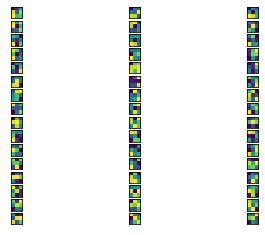

conv2d_1 (None, 100, 100, 32)
32


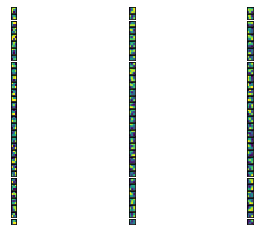

conv2d_2 (None, 100, 100, 64)
64


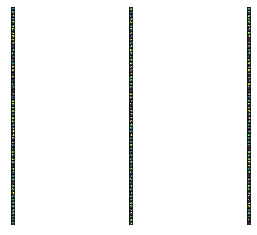

In [27]:
#Iterate thru all the layers of the model
for layer in model.layers[0:8]:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name, layer.output_shape)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

### Visualizing Feature maps or Activation maps generated in a CNN

In [31]:
img_path_colab='/content/Coins/big data set/original/2e/IMG_20190611_130947_0.jpg'
img_path_local='big data set/original/2e/IMG_20190611_130947_0.jpg' #Coin

(1, 100, 100, 16)
(1, 100, 100, 16)
(1, 100, 100, 32)
(1, 100, 100, 32)
(1, 100, 100, 64)
(1, 100, 100, 64)
(1, 100, 100, 64)


invalid value encountered in true_divide
divide by zero encountered in true_divide


(1, 100, 100, 64)
(1, 50, 50, 64)
(1, 50, 50, 64)
(1, 50, 50, 64)
(1, 50, 50, 128)
(1, 50, 50, 128)
(1, 50, 50, 128)
(1, 50, 50, 128)
(1, 25, 25, 128)
(1, 25, 25, 128)
(1, 25, 25, 128)
(1, 25, 25, 256)
(1, 25, 25, 256)
(1, 25, 25, 256)
(1, 25, 25, 256)
(1, 13, 13, 256)
(1, 13, 13, 256)
(1, 13, 13, 256)


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(1, 13, 13, 512)
(1, 13, 13, 512)
(1, 13, 13, 512)
(1, 13, 13, 512)
(1, 7, 7, 512)
(1, 7, 7, 512)
(1, 7, 7, 512)
(1, 7, 7, 728)
(1, 7, 7, 728)
(1, 7, 7, 728)
(1, 35672)
(1, 8)


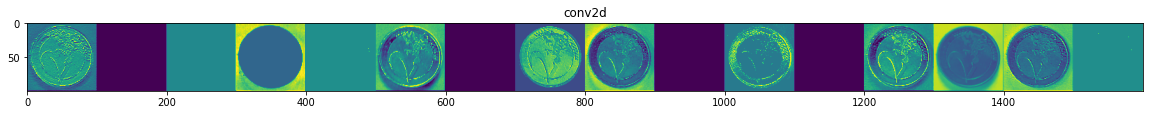

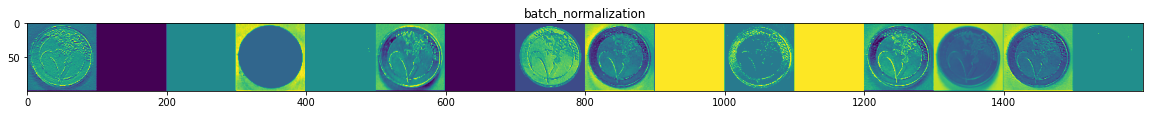

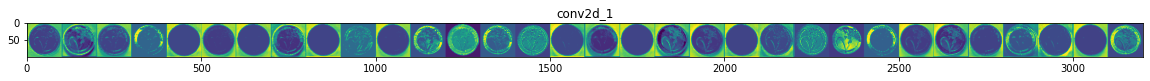

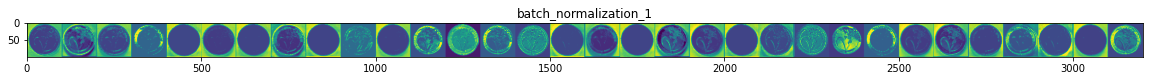

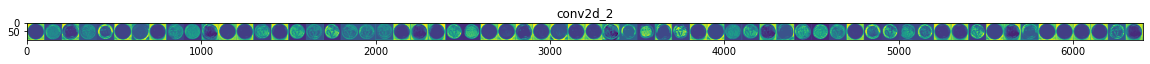

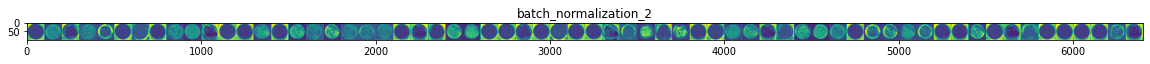

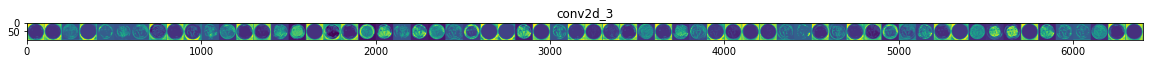

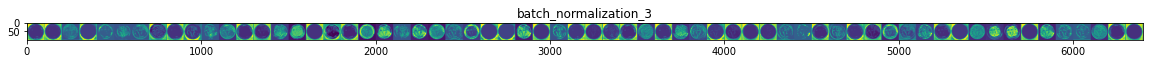

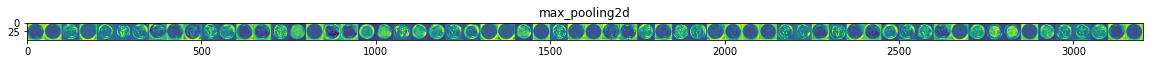

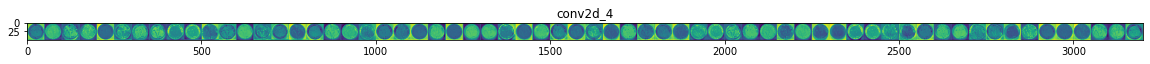

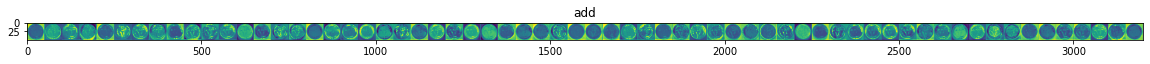

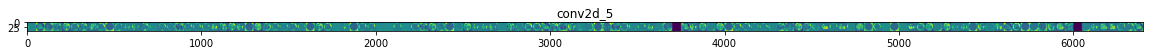

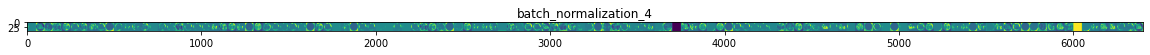

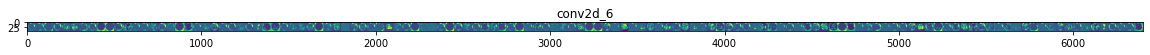

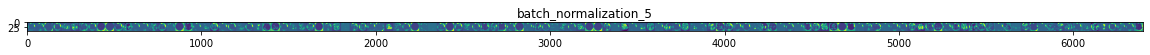

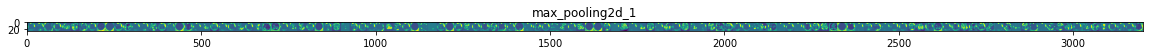

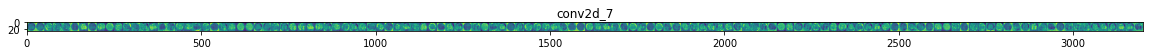

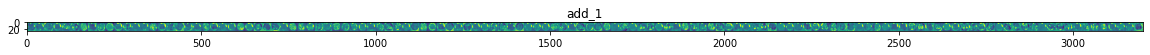

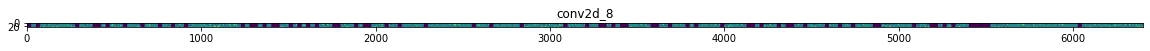

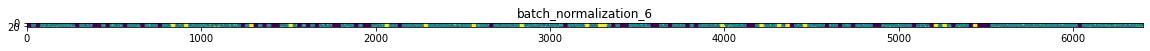

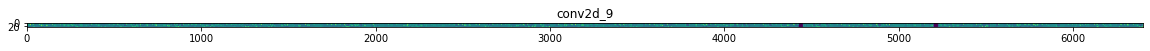

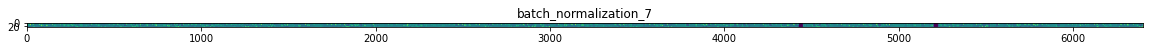

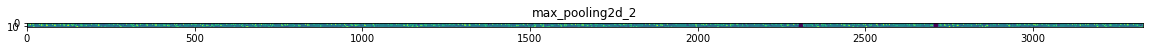

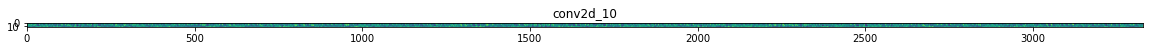

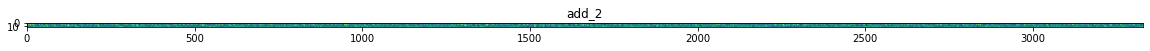

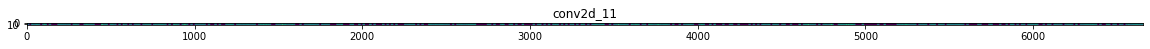

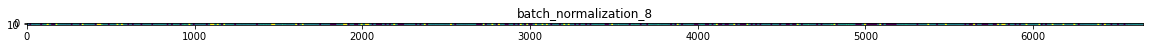

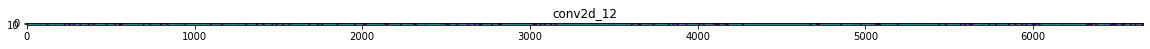

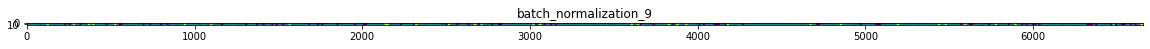

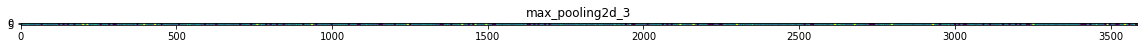

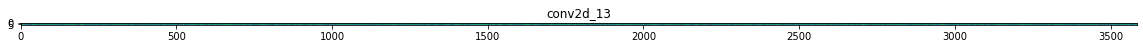

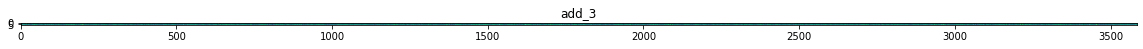

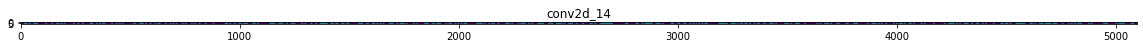

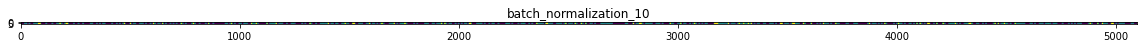

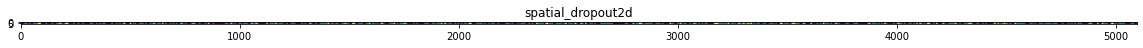

In [32]:


# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[3:]] #[n:](n=1,2,3) random_flip caused error Muss vllt. weiter angepasst werden
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path_colab, target_size=(200, 200))
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
#x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[3:]]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

In [7]:
datagen=ImageDataGenerator(rescale=1./255,
    validation_split=0.20)

batch_size=64   
dir_colab ="/content/Coins/new_extended_dataset/original"
dir_local ="new_extended_dataset/original"
target_size = 200

train_data = datagen.flow_from_directory(dir_colab,
    target_size=(target_size,target_size),
    class_mode="categorical", 
    batch_size=batch_size, 
    subset="training")

val_data = datagen.flow_from_directory(dir_colab,
    target_size=(target_size,target_size),
    class_mode="categorical", 
    batch_size=batch_size, 
    subset="validation")

Found 7734 images belonging to 8 classes.
Found 1930 images belonging to 8 classes.


In [8]:
x_train, y_train = train_data.next()
x_test, y_test = val_data.next()

In [13]:
explainer = shap.GradientExplainer(model, x_train)

In [14]:
shap_values = explainer.shap_values(x_test[:3])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [15]:
print(len(shap_values))

8


In [20]:
print(len(shap_values[0]))

3


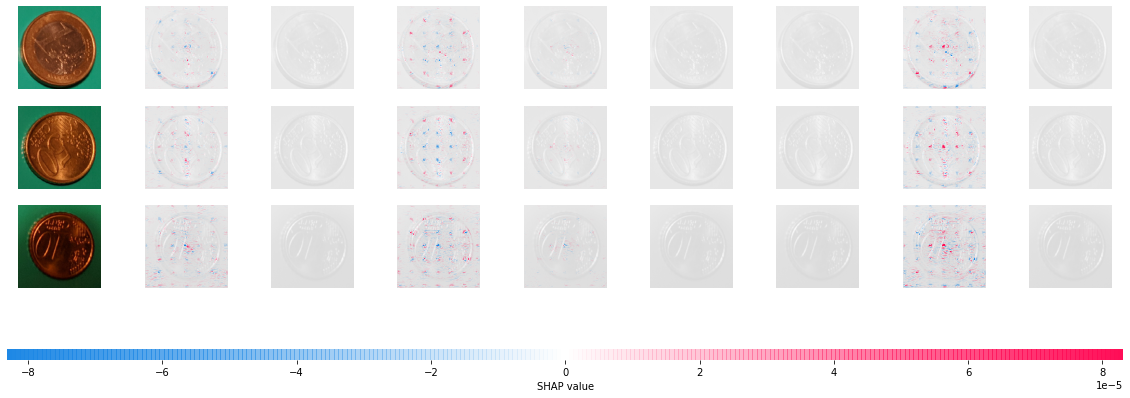

In [26]:
shap.image_plot([shap_values[i] for i in range(8)], x_test[:3])